# 프로젝트 : Segmentation map으로 도로 이미지 만들기

## 1. 데이터 준비하기

In [1]:
import os

# 데이터 불러오기
train_data_path = os.getenv('HOME')+'/aiffel/aiffel_quest/quest_exp_07/cityscapes/train/'
test_data_path = os.getenv('HOME')+'/aiffel/aiffel_quest/quest_exp_07/cityscapes/val/'
print("number of train examples :", len(os.listdir(train_data_path)))
print("number of test examples :", len(os.listdir(test_data_path)))

number of train examples : 1000
number of test examples : 5


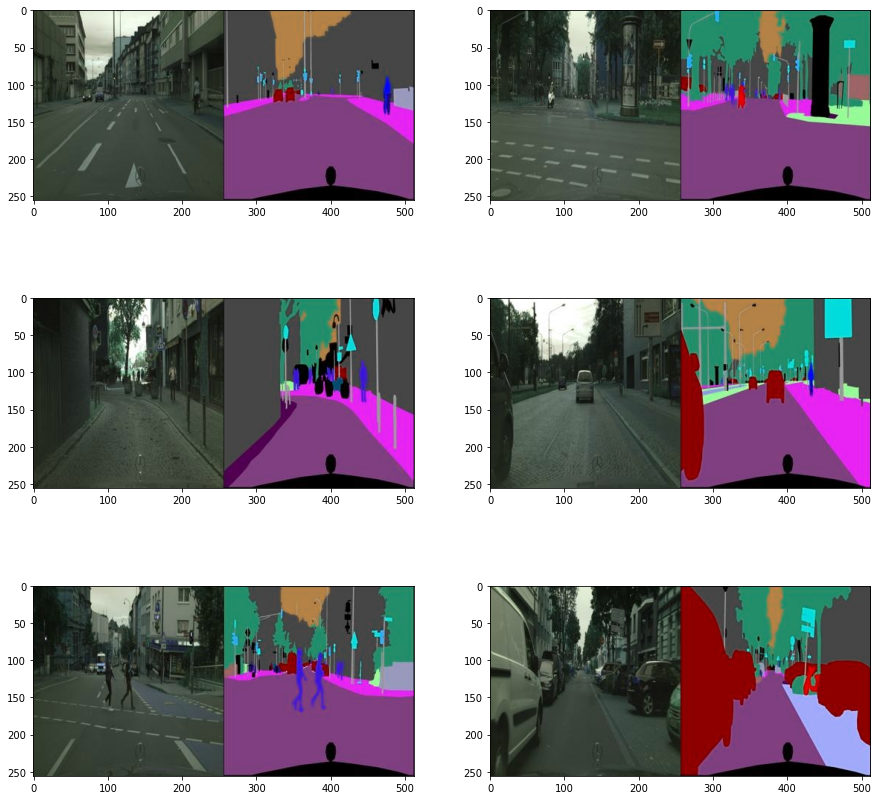

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 이미지 확인하기
plt.figure(figsize=(15,15))
for i in range(1, 7):
    f = train_data_path + os.listdir(train_data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
# 이미지 크기 확인
f = train_data_path + os.listdir(train_data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


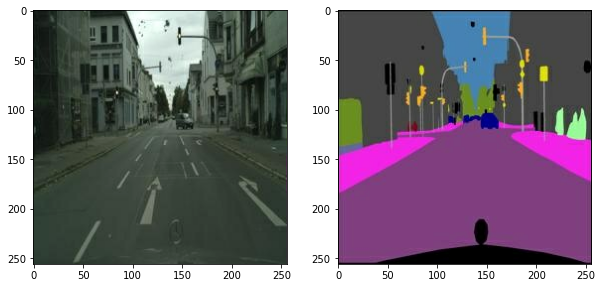

In [4]:
# 이미지 분할하기

import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = train_data_path + os.listdir(train_data_path)[1]
orig, seg = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(orig))
plt.subplot(1,2,2); plt.imshow(denormalize(seg))

In [5]:
# 이미지 데이터 augmentation 정의

from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(orig, seg):
    stacked = tf.concat([orig, seg], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    
    padded = tf.pad(stacked, _pad, "REFLECT") # 반사 패딩 적용

    out = image.random_crop(padded, size=[256, 256, 6]) # 임의의 영역 크롭
    out = image.random_flip_left_right(out) # 50% 확률로 좌우 반전
    out = image.random_flip_up_down(out) # 50% 확률로 90도 단위 회전
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

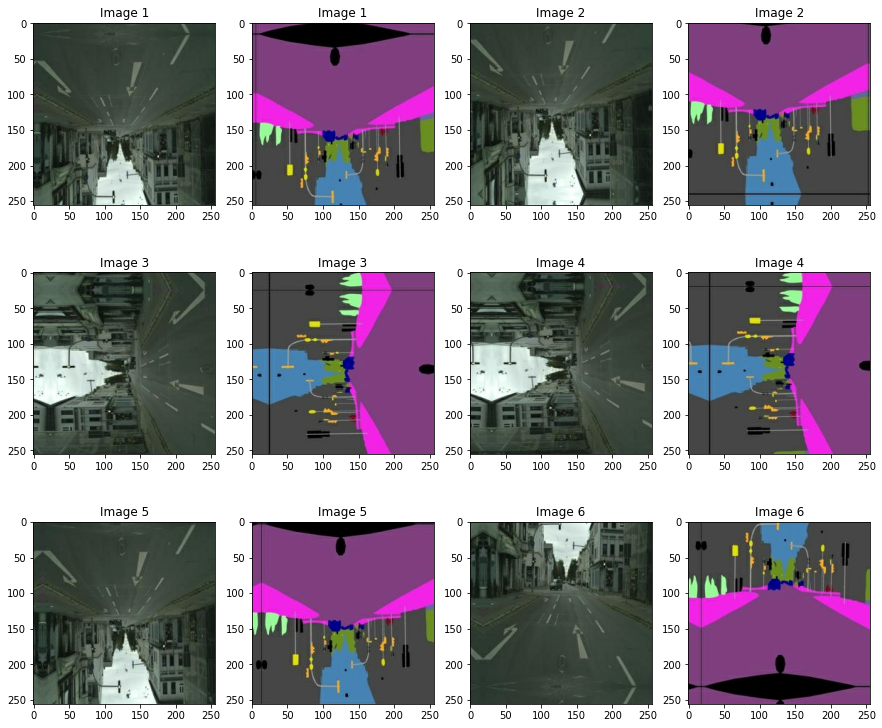

In [6]:
# augmentation 결과 확인

plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_orig, augmented_seg = apply_augmentation(orig, seg)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_orig)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    img_n += 1

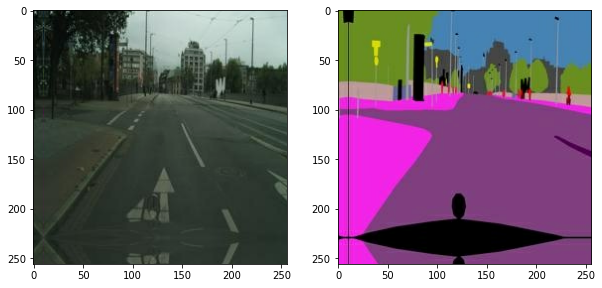

In [7]:
# 전체 데이터 augmentation 적용

from tensorflow import data

def get_train(img_path):
    orig, seg = load_img(img_path)
    orig, seg = apply_augmentation(orig, seg)
    return orig, seg

train_images = data.Dataset.list_files(train_data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
orig, seg = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(orig[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(seg[0].astype(np.uint8))

## 2. Generator 구성하기

In [8]:
# 인코더 블럭 정의

from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
 

In [9]:
# 디코더 블럭 정의

class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    

In [10]:
# generator 정의

class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [11]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 3. Discriminator 구성하기

In [12]:
# discriminator 블럭 정의

class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [13]:
# discriminator 정의

class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        for i, n_filt in enumerate(filters):
            if i < 3: 
                stride=2
                custom_pad = False   
            else: 
                stride = 1
                custom_pad = True
            if i in [0,4]:
                use_bn = False 
            else:
                use_bn = True
            if i < 4:
                act = True  
            else: 
                act = False
            self.blocks.append(DiscBlock(n_filters=n_filt, stride=stride, custom_pad=custom_pad, use_bn=use_bn, act=act))
    
    def sigmoid(self, out):
        return tf.math.sigmoid(out)

    def call(self, x, y):
        #[[YOUR CODE]]
        out = [x, y]
        for block in self.blocks:
            out = block(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()


In [14]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

## 4. 학습 및 테스트하기

In [15]:
# 손실 함수 정의

from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)


In [16]:
# optimizer 정의

from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [17]:
generator = UNetGenerator()
discriminator = Discriminator()

@tf.function
def train_step(seg, real_orig):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # generator 이용해 가짜 이미지 생성
        fake_orig = generator(seg)
        # discriminator 이용해 진짜 및 가짜 이미지를 판별
        real_out = discriminator(real_orig, seg)
        fake_out = discriminator(fake_orig, seg)
        # loss 계산
        gene_loss, l1_loss = get_gene_loss(fake_orig, real_orig, fake_out)
        gene_total_loss = gene_loss + 100 * l1_loss
        disc_loss = get_disc_loss(fake_out, real_out)

        # gradient 계산
        gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
        disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


In [18]:
EPOCHS = 250

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (orig, seg) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(seg, orig)
                
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[50]                     
Generator_loss:0.7774                     
L1_loss:0.2088                     
Discriminator_loss:1.1150

EPOCH[1] - STEP[100]                     
Generator_loss:0.7982                     
L1_loss:0.2217                     
Discriminator_loss:1.3278

EPOCH[1] - STEP[150]                     
Generator_loss:0.6523                     
L1_loss:0.2001                     
Discriminator_loss:1.1847

EPOCH[1] - STEP[200]                     
Generator_loss:1.3234                     
L1_loss:0.1985                     
Discriminator_loss:0.7429

EPOCH[1] - STEP[250]                     
Generator_loss:0.9444                     
L1_loss:0.2034                     
Discriminator_loss:0.8871

EPOCH[2] - STEP[50]                     
Generator_loss:0.7289                     
L1_loss:0.1571                     
Discriminator_loss:1.3671

EPOCH[2] - STEP[100]                     
Generator_loss:0.8363                     
L1_loss:0.2179               

EPOCH[12] - STEP[100]                     
Generator_loss:2.0190                     
L1_loss:0.1653                     
Discriminator_loss:1.1542

EPOCH[12] - STEP[150]                     
Generator_loss:1.5234                     
L1_loss:0.1719                     
Discriminator_loss:0.8234

EPOCH[12] - STEP[200]                     
Generator_loss:1.2791                     
L1_loss:0.1805                     
Discriminator_loss:0.6995

EPOCH[12] - STEP[250]                     
Generator_loss:2.0918                     
L1_loss:0.1426                     
Discriminator_loss:0.8975

EPOCH[13] - STEP[50]                     
Generator_loss:1.2371                     
L1_loss:0.1718                     
Discriminator_loss:0.9217

EPOCH[13] - STEP[100]                     
Generator_loss:1.7220                     
L1_loss:0.1624                     
Discriminator_loss:0.5594

EPOCH[13] - STEP[150]                     
Generator_loss:0.8614                     
L1_loss:0.1809       

EPOCH[23] - STEP[150]                     
Generator_loss:2.2100                     
L1_loss:0.1845                     
Discriminator_loss:0.6128

EPOCH[23] - STEP[200]                     
Generator_loss:1.5153                     
L1_loss:0.1519                     
Discriminator_loss:0.8548

EPOCH[23] - STEP[250]                     
Generator_loss:1.6594                     
L1_loss:0.1746                     
Discriminator_loss:0.5287

EPOCH[24] - STEP[50]                     
Generator_loss:1.3269                     
L1_loss:0.1914                     
Discriminator_loss:0.8194

EPOCH[24] - STEP[100]                     
Generator_loss:2.1171                     
L1_loss:0.1853                     
Discriminator_loss:0.5370

EPOCH[24] - STEP[150]                     
Generator_loss:1.6872                     
L1_loss:0.1718                     
Discriminator_loss:0.6998

EPOCH[24] - STEP[200]                     
Generator_loss:2.2635                     
L1_loss:0.1753       

EPOCH[34] - STEP[200]                     
Generator_loss:1.2788                     
L1_loss:0.1946                     
Discriminator_loss:0.9331

EPOCH[34] - STEP[250]                     
Generator_loss:1.4886                     
L1_loss:0.1818                     
Discriminator_loss:1.1186

EPOCH[35] - STEP[50]                     
Generator_loss:0.9725                     
L1_loss:0.1177                     
Discriminator_loss:1.1419

EPOCH[35] - STEP[100]                     
Generator_loss:1.6706                     
L1_loss:0.1616                     
Discriminator_loss:0.9619

EPOCH[35] - STEP[150]                     
Generator_loss:1.6816                     
L1_loss:0.1565                     
Discriminator_loss:0.6398

EPOCH[35] - STEP[200]                     
Generator_loss:1.6346                     
L1_loss:0.1582                     
Discriminator_loss:0.8635

EPOCH[35] - STEP[250]                     
Generator_loss:1.7060                     
L1_loss:0.1963       

EPOCH[45] - STEP[250]                     
Generator_loss:1.8692                     
L1_loss:0.1711                     
Discriminator_loss:1.0264

EPOCH[46] - STEP[50]                     
Generator_loss:1.8212                     
L1_loss:0.1871                     
Discriminator_loss:0.8408

EPOCH[46] - STEP[100]                     
Generator_loss:0.9518                     
L1_loss:0.1350                     
Discriminator_loss:0.9927

EPOCH[46] - STEP[150]                     
Generator_loss:2.1030                     
L1_loss:0.1711                     
Discriminator_loss:1.0270

EPOCH[46] - STEP[200]                     
Generator_loss:1.9820                     
L1_loss:0.1696                     
Discriminator_loss:0.5749

EPOCH[46] - STEP[250]                     
Generator_loss:1.5373                     
L1_loss:0.1463                     
Discriminator_loss:0.5980

EPOCH[47] - STEP[50]                     
Generator_loss:1.5121                     
L1_loss:0.2036        

EPOCH[57] - STEP[50]                     
Generator_loss:2.0678                     
L1_loss:0.1781                     
Discriminator_loss:0.4406

EPOCH[57] - STEP[100]                     
Generator_loss:1.6314                     
L1_loss:0.1687                     
Discriminator_loss:1.0696

EPOCH[57] - STEP[150]                     
Generator_loss:1.5763                     
L1_loss:0.1596                     
Discriminator_loss:0.7013

EPOCH[57] - STEP[200]                     
Generator_loss:1.6845                     
L1_loss:0.1549                     
Discriminator_loss:0.9119

EPOCH[57] - STEP[250]                     
Generator_loss:2.2264                     
L1_loss:0.1652                     
Discriminator_loss:1.0540

EPOCH[58] - STEP[50]                     
Generator_loss:1.7581                     
L1_loss:0.1334                     
Discriminator_loss:0.7201

EPOCH[58] - STEP[100]                     
Generator_loss:1.3188                     
L1_loss:0.1843        

EPOCH[68] - STEP[100]                     
Generator_loss:1.2701                     
L1_loss:0.1505                     
Discriminator_loss:0.9372

EPOCH[68] - STEP[150]                     
Generator_loss:1.7483                     
L1_loss:0.1449                     
Discriminator_loss:0.9586

EPOCH[68] - STEP[200]                     
Generator_loss:1.3609                     
L1_loss:0.1424                     
Discriminator_loss:0.8514

EPOCH[68] - STEP[250]                     
Generator_loss:2.2233                     
L1_loss:0.1975                     
Discriminator_loss:0.5795

EPOCH[69] - STEP[50]                     
Generator_loss:1.7946                     
L1_loss:0.1848                     
Discriminator_loss:0.9319

EPOCH[69] - STEP[100]                     
Generator_loss:2.0539                     
L1_loss:0.1588                     
Discriminator_loss:0.6011

EPOCH[69] - STEP[150]                     
Generator_loss:1.8148                     
L1_loss:0.1469       

EPOCH[79] - STEP[150]                     
Generator_loss:1.5001                     
L1_loss:0.1322                     
Discriminator_loss:0.8467

EPOCH[79] - STEP[200]                     
Generator_loss:1.8974                     
L1_loss:0.1477                     
Discriminator_loss:0.7751

EPOCH[79] - STEP[250]                     
Generator_loss:2.2726                     
L1_loss:0.1520                     
Discriminator_loss:0.8846

EPOCH[80] - STEP[50]                     
Generator_loss:1.2185                     
L1_loss:0.1763                     
Discriminator_loss:1.1322

EPOCH[80] - STEP[100]                     
Generator_loss:1.8124                     
L1_loss:0.1475                     
Discriminator_loss:0.6792

EPOCH[80] - STEP[150]                     
Generator_loss:1.7465                     
L1_loss:0.1599                     
Discriminator_loss:1.0694

EPOCH[80] - STEP[200]                     
Generator_loss:1.8789                     
L1_loss:0.2009       

EPOCH[90] - STEP[200]                     
Generator_loss:1.5437                     
L1_loss:0.1453                     
Discriminator_loss:0.7000

EPOCH[90] - STEP[250]                     
Generator_loss:1.7397                     
L1_loss:0.1610                     
Discriminator_loss:0.9252

EPOCH[91] - STEP[50]                     
Generator_loss:1.1432                     
L1_loss:0.1656                     
Discriminator_loss:0.8885

EPOCH[91] - STEP[100]                     
Generator_loss:2.0727                     
L1_loss:0.1385                     
Discriminator_loss:1.2445

EPOCH[91] - STEP[150]                     
Generator_loss:1.6143                     
L1_loss:0.1766                     
Discriminator_loss:0.6593

EPOCH[91] - STEP[200]                     
Generator_loss:1.5819                     
L1_loss:0.1470                     
Discriminator_loss:0.9153

EPOCH[91] - STEP[250]                     
Generator_loss:1.7092                     
L1_loss:0.1742       

EPOCH[101] - STEP[250]                     
Generator_loss:1.8284                     
L1_loss:0.1495                     
Discriminator_loss:0.7658

EPOCH[102] - STEP[50]                     
Generator_loss:1.7643                     
L1_loss:0.1748                     
Discriminator_loss:0.9090

EPOCH[102] - STEP[100]                     
Generator_loss:1.5885                     
L1_loss:0.1719                     
Discriminator_loss:0.6760

EPOCH[102] - STEP[150]                     
Generator_loss:1.4978                     
L1_loss:0.1534                     
Discriminator_loss:0.8381

EPOCH[102] - STEP[200]                     
Generator_loss:1.8290                     
L1_loss:0.1595                     
Discriminator_loss:0.5966

EPOCH[102] - STEP[250]                     
Generator_loss:1.6326                     
L1_loss:0.1465                     
Discriminator_loss:0.8266

EPOCH[103] - STEP[50]                     
Generator_loss:1.5765                     
L1_loss:0.1483 

EPOCH[112] - STEP[250]                     
Generator_loss:1.4861                     
L1_loss:0.1451                     
Discriminator_loss:0.8107

EPOCH[113] - STEP[50]                     
Generator_loss:1.6850                     
L1_loss:0.1765                     
Discriminator_loss:0.7588

EPOCH[113] - STEP[100]                     
Generator_loss:1.8295                     
L1_loss:0.1551                     
Discriminator_loss:0.8249

EPOCH[113] - STEP[150]                     
Generator_loss:1.3204                     
L1_loss:0.1370                     
Discriminator_loss:0.8888

EPOCH[113] - STEP[200]                     
Generator_loss:1.3344                     
L1_loss:0.1581                     
Discriminator_loss:0.6919

EPOCH[113] - STEP[250]                     
Generator_loss:1.8490                     
L1_loss:0.1516                     
Discriminator_loss:0.6611

EPOCH[114] - STEP[50]                     
Generator_loss:1.5396                     
L1_loss:0.1984 

EPOCH[123] - STEP[250]                     
Generator_loss:1.2900                     
L1_loss:0.1338                     
Discriminator_loss:1.2065

EPOCH[124] - STEP[50]                     
Generator_loss:1.9829                     
L1_loss:0.1946                     
Discriminator_loss:0.7123

EPOCH[124] - STEP[100]                     
Generator_loss:1.7468                     
L1_loss:0.1522                     
Discriminator_loss:0.7711

EPOCH[124] - STEP[150]                     
Generator_loss:1.6631                     
L1_loss:0.1605                     
Discriminator_loss:0.6330

EPOCH[124] - STEP[200]                     
Generator_loss:1.7004                     
L1_loss:0.2176                     
Discriminator_loss:0.7195

EPOCH[124] - STEP[250]                     
Generator_loss:1.4896                     
L1_loss:0.1518                     
Discriminator_loss:0.7488

EPOCH[125] - STEP[50]                     
Generator_loss:1.6370                     
L1_loss:0.1402 

EPOCH[134] - STEP[250]                     
Generator_loss:1.8395                     
L1_loss:0.1456                     
Discriminator_loss:0.9476

EPOCH[135] - STEP[50]                     
Generator_loss:0.9635                     
L1_loss:0.1364                     
Discriminator_loss:1.0930

EPOCH[135] - STEP[100]                     
Generator_loss:1.5522                     
L1_loss:0.1655                     
Discriminator_loss:0.7444

EPOCH[135] - STEP[150]                     
Generator_loss:1.4506                     
L1_loss:0.1425                     
Discriminator_loss:0.8977

EPOCH[135] - STEP[200]                     
Generator_loss:1.4673                     
L1_loss:0.1487                     
Discriminator_loss:0.7558

EPOCH[135] - STEP[250]                     
Generator_loss:1.6408                     
L1_loss:0.1366                     
Discriminator_loss:0.7002

EPOCH[136] - STEP[50]                     
Generator_loss:1.5214                     
L1_loss:0.1819 

EPOCH[145] - STEP[250]                     
Generator_loss:1.1371                     
L1_loss:0.1362                     
Discriminator_loss:0.9865

EPOCH[146] - STEP[50]                     
Generator_loss:1.3600                     
L1_loss:0.1617                     
Discriminator_loss:1.1838

EPOCH[146] - STEP[100]                     
Generator_loss:1.7833                     
L1_loss:0.1518                     
Discriminator_loss:0.7526

EPOCH[146] - STEP[150]                     
Generator_loss:1.6554                     
L1_loss:0.1684                     
Discriminator_loss:0.5004

EPOCH[146] - STEP[200]                     
Generator_loss:1.6801                     
L1_loss:0.1593                     
Discriminator_loss:0.8885

EPOCH[146] - STEP[250]                     
Generator_loss:1.4532                     
L1_loss:0.1693                     
Discriminator_loss:0.7268

EPOCH[147] - STEP[50]                     
Generator_loss:1.3927                     
L1_loss:0.1588 

EPOCH[156] - STEP[250]                     
Generator_loss:1.9442                     
L1_loss:0.1354                     
Discriminator_loss:1.1468

EPOCH[157] - STEP[50]                     
Generator_loss:1.3969                     
L1_loss:0.1629                     
Discriminator_loss:0.7739

EPOCH[157] - STEP[100]                     
Generator_loss:1.8978                     
L1_loss:0.1322                     
Discriminator_loss:0.8115

EPOCH[157] - STEP[150]                     
Generator_loss:1.9729                     
L1_loss:0.1598                     
Discriminator_loss:0.6549

EPOCH[157] - STEP[200]                     
Generator_loss:1.5335                     
L1_loss:0.1578                     
Discriminator_loss:0.9415

EPOCH[157] - STEP[250]                     
Generator_loss:1.7620                     
L1_loss:0.1347                     
Discriminator_loss:0.8420

EPOCH[158] - STEP[50]                     
Generator_loss:1.6214                     
L1_loss:0.1516 

EPOCH[167] - STEP[250]                     
Generator_loss:1.7489                     
L1_loss:0.1548                     
Discriminator_loss:0.8668

EPOCH[168] - STEP[50]                     
Generator_loss:1.3641                     
L1_loss:0.1541                     
Discriminator_loss:0.9470

EPOCH[168] - STEP[100]                     
Generator_loss:1.4055                     
L1_loss:0.1705                     
Discriminator_loss:0.9604

EPOCH[168] - STEP[150]                     
Generator_loss:2.0541                     
L1_loss:0.2017                     
Discriminator_loss:0.5365

EPOCH[168] - STEP[200]                     
Generator_loss:2.0408                     
L1_loss:0.2061                     
Discriminator_loss:0.4667

EPOCH[168] - STEP[250]                     
Generator_loss:1.8267                     
L1_loss:0.1458                     
Discriminator_loss:0.7411

EPOCH[169] - STEP[50]                     
Generator_loss:1.2943                     
L1_loss:0.1508 

EPOCH[178] - STEP[250]                     
Generator_loss:1.7816                     
L1_loss:0.1290                     
Discriminator_loss:0.6685

EPOCH[179] - STEP[50]                     
Generator_loss:2.0775                     
L1_loss:0.1448                     
Discriminator_loss:0.6534

EPOCH[179] - STEP[100]                     
Generator_loss:1.6445                     
L1_loss:0.1195                     
Discriminator_loss:0.9362

EPOCH[179] - STEP[150]                     
Generator_loss:1.8516                     
L1_loss:0.1959                     
Discriminator_loss:0.7583

EPOCH[179] - STEP[200]                     
Generator_loss:1.9353                     
L1_loss:0.1540                     
Discriminator_loss:0.8146

EPOCH[179] - STEP[250]                     
Generator_loss:1.6278                     
L1_loss:0.1823                     
Discriminator_loss:0.7940

EPOCH[180] - STEP[50]                     
Generator_loss:1.9815                     
L1_loss:0.1587 

EPOCH[189] - STEP[250]                     
Generator_loss:1.3915                     
L1_loss:0.1293                     
Discriminator_loss:0.9974

EPOCH[190] - STEP[50]                     
Generator_loss:1.4278                     
L1_loss:0.1365                     
Discriminator_loss:0.6713

EPOCH[190] - STEP[100]                     
Generator_loss:1.6808                     
L1_loss:0.1241                     
Discriminator_loss:0.8754

EPOCH[190] - STEP[150]                     
Generator_loss:1.4548                     
L1_loss:0.1533                     
Discriminator_loss:0.9099

EPOCH[190] - STEP[200]                     
Generator_loss:1.9606                     
L1_loss:0.1792                     
Discriminator_loss:0.5333

EPOCH[190] - STEP[250]                     
Generator_loss:0.7646                     
L1_loss:0.1326                     
Discriminator_loss:1.2944

EPOCH[191] - STEP[50]                     
Generator_loss:2.1294                     
L1_loss:0.1331 

EPOCH[200] - STEP[250]                     
Generator_loss:1.3826                     
L1_loss:0.1463                     
Discriminator_loss:0.7504

EPOCH[201] - STEP[50]                     
Generator_loss:2.8221                     
L1_loss:0.1768                     
Discriminator_loss:0.5132

EPOCH[201] - STEP[100]                     
Generator_loss:1.7845                     
L1_loss:0.1467                     
Discriminator_loss:0.7625

EPOCH[201] - STEP[150]                     
Generator_loss:1.9744                     
L1_loss:0.1449                     
Discriminator_loss:0.6602

EPOCH[201] - STEP[200]                     
Generator_loss:2.3999                     
L1_loss:0.1358                     
Discriminator_loss:0.7370

EPOCH[201] - STEP[250]                     
Generator_loss:1.3355                     
L1_loss:0.1371                     
Discriminator_loss:0.7990

EPOCH[202] - STEP[50]                     
Generator_loss:1.4466                     
L1_loss:0.1470 

EPOCH[211] - STEP[250]                     
Generator_loss:1.7403                     
L1_loss:0.1632                     
Discriminator_loss:0.7433

EPOCH[212] - STEP[50]                     
Generator_loss:1.9805                     
L1_loss:0.1418                     
Discriminator_loss:0.5399

EPOCH[212] - STEP[100]                     
Generator_loss:1.6553                     
L1_loss:0.1164                     
Discriminator_loss:0.9781

EPOCH[212] - STEP[150]                     
Generator_loss:1.8129                     
L1_loss:0.1392                     
Discriminator_loss:0.6806

EPOCH[212] - STEP[200]                     
Generator_loss:1.6733                     
L1_loss:0.1291                     
Discriminator_loss:0.6550

EPOCH[212] - STEP[250]                     
Generator_loss:1.6601                     
L1_loss:0.1674                     
Discriminator_loss:0.7161

EPOCH[213] - STEP[50]                     
Generator_loss:1.9896                     
L1_loss:0.1202 

EPOCH[222] - STEP[250]                     
Generator_loss:1.4729                     
L1_loss:0.1435                     
Discriminator_loss:0.7581

EPOCH[223] - STEP[50]                     
Generator_loss:1.8788                     
L1_loss:0.1450                     
Discriminator_loss:0.9445

EPOCH[223] - STEP[100]                     
Generator_loss:2.4781                     
L1_loss:0.1373                     
Discriminator_loss:0.8355

EPOCH[223] - STEP[150]                     
Generator_loss:1.7252                     
L1_loss:0.1797                     
Discriminator_loss:0.5739

EPOCH[223] - STEP[200]                     
Generator_loss:2.1604                     
L1_loss:0.1376                     
Discriminator_loss:0.7525

EPOCH[223] - STEP[250]                     
Generator_loss:1.6436                     
L1_loss:0.1250                     
Discriminator_loss:0.6916

EPOCH[224] - STEP[50]                     
Generator_loss:1.3800                     
L1_loss:0.1271 

EPOCH[233] - STEP[250]                     
Generator_loss:1.4764                     
L1_loss:0.1279                     
Discriminator_loss:0.9331

EPOCH[234] - STEP[50]                     
Generator_loss:1.8733                     
L1_loss:0.1459                     
Discriminator_loss:0.6547

EPOCH[234] - STEP[100]                     
Generator_loss:1.7082                     
L1_loss:0.1578                     
Discriminator_loss:0.7440

EPOCH[234] - STEP[150]                     
Generator_loss:1.8986                     
L1_loss:0.2132                     
Discriminator_loss:0.7889

EPOCH[234] - STEP[200]                     
Generator_loss:1.9109                     
L1_loss:0.1376                     
Discriminator_loss:0.7322

EPOCH[234] - STEP[250]                     
Generator_loss:1.1769                     
L1_loss:0.1571                     
Discriminator_loss:0.8334

EPOCH[235] - STEP[50]                     
Generator_loss:1.8868                     
L1_loss:0.2181 

EPOCH[244] - STEP[250]                     
Generator_loss:1.9682                     
L1_loss:0.1362                     
Discriminator_loss:0.7230

EPOCH[245] - STEP[50]                     
Generator_loss:1.6669                     
L1_loss:0.1158                     
Discriminator_loss:0.7044

EPOCH[245] - STEP[100]                     
Generator_loss:2.0967                     
L1_loss:0.1042                     
Discriminator_loss:1.0316

EPOCH[245] - STEP[150]                     
Generator_loss:1.4306                     
L1_loss:0.1980                     
Discriminator_loss:1.0710

EPOCH[245] - STEP[200]                     
Generator_loss:1.9854                     
L1_loss:0.1629                     
Discriminator_loss:0.9581

EPOCH[245] - STEP[250]                     
Generator_loss:1.4919                     
L1_loss:0.1388                     
Discriminator_loss:0.7807

EPOCH[246] - STEP[50]                     
Generator_loss:1.3150                     
L1_loss:0.1488 

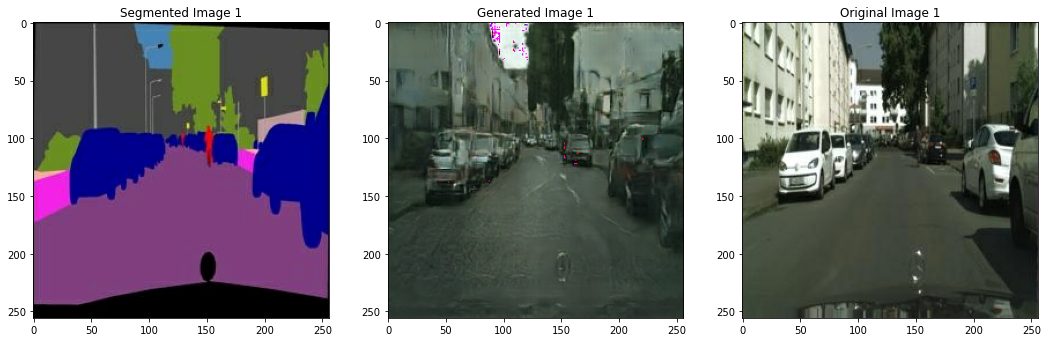

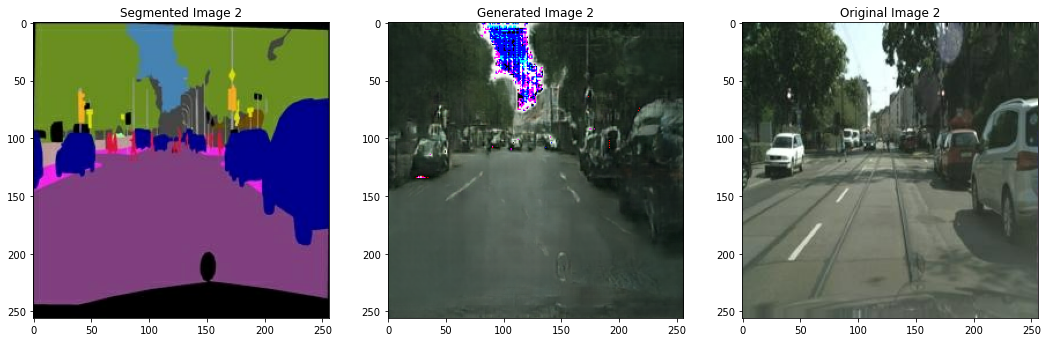

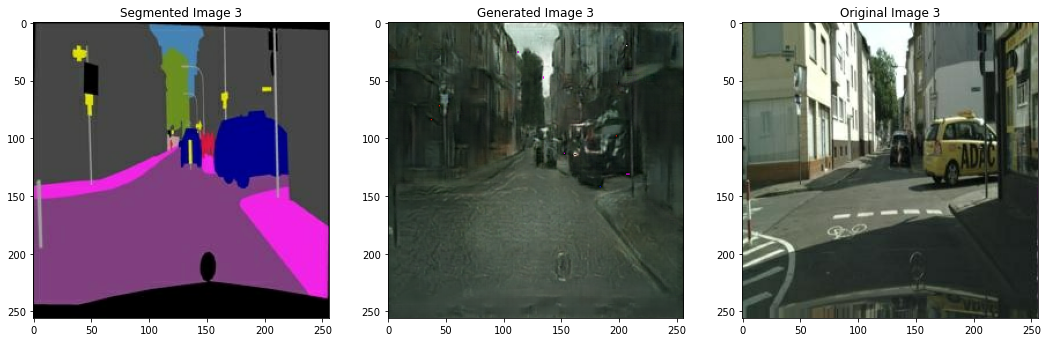

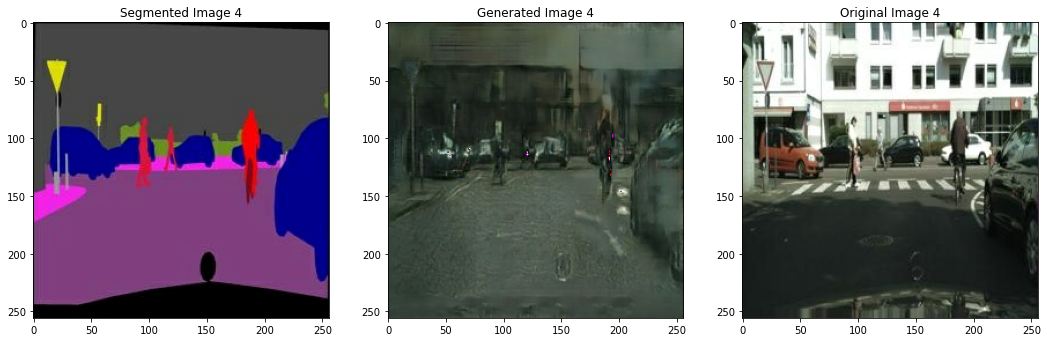

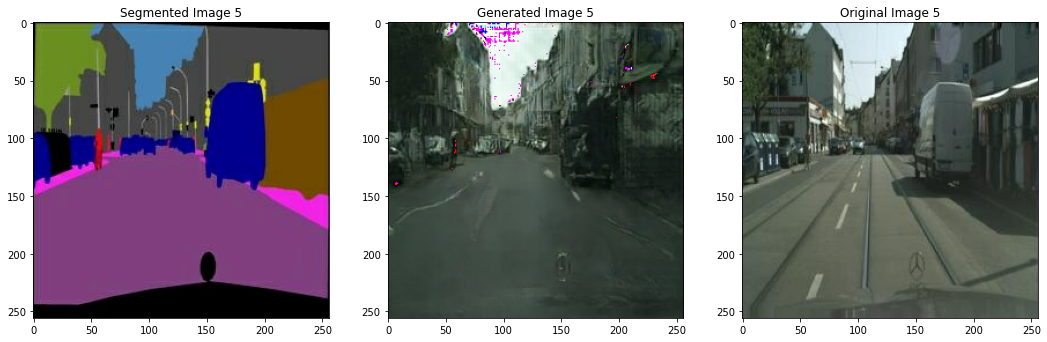

In [19]:

for i in range(1, 5+1):
    f = test_data_path + os.listdir(test_data_path)[i-1]
    orig, seg = load_img(f)

    pred = generator(tf.expand_dims(seg, 0))
    pred = denormalize(pred)
    plt.figure(figsize=(18,35))
    plt.subplot(i,3,3*i-2); plt.imshow(denormalize(seg))
    plt.gca().title.set_text(f'Segmented Image {i}')
    plt.subplot(i,3,3*i-1); plt.imshow(pred[0])
    plt.gca().title.set_text(f'Generated Image {i}')
    plt.subplot(i,3,3*i); plt.imshow(denormalize(orig))
    plt.gca().title.set_text(f'Original Image {i}')

## 회고

- 이번 프로젝트는 다음과 같이 진행했다.
    - 데이터 전처리
        - 주어진 이미지를 original 이미지와 segmented 이미지로 분리
        - 데이터 augmentation (패딩 후 크롭, 대칭변환, 회전변환)
    - Generator 생성
        - 인코더, 디코더를 이루는 블록을 설계한 후 Unet 구조로 이어붙이기
    - Discriminator 생성
    - 학습 및 테스트
        - 손실 함수에 GAN loss와 L1 loss를 모두 반영
- Generator와 Discriminator의 구조는 기본적으로 합성곱 신경망을 쌓은 것이다. 추가적으로 skip connection을 활용한 Unet 구조가 특기할만한 점.
- ~~Discriminator에 2개의 입력을 넣는 부분이 잘 이해가 되지 않는다.~~
    - cGAN에서 discriminator에 조건에 대한 정보와 fake/real image를 넣어주는데, pix2pix에서는 조건이 처음 입력 이미지로 대체되었다고 생각하면 되겠다!
- gradient tape을 이용해 손실 함수를 커스터마이징하는 것이 가능하다.
- epoch=250으로 학습한 결과물을 보면 그림 속 개체들이 무엇인지 파악이 가능하나 '색칠이 덜 된 부분'이 존재했다. 
- subclassing을 이용한 모델 구현이 모델을 원하는대로 구현하기에 좋은 방법이라는 점이 느껴졌다. 그만큼 신경써서 코딩을 해야할 필요도 있다.